In [1]:
import numpy as np
import torch
import torch_geometric
import open3d as o3d
#utils
import h5py
import os
import dataclasses
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from ChamferDistancePytorch.chamfer3D.dist_chamfer_3D import chamfer_3DDist as ChamferLoss
from sklearn.model_selection import train_test_split
from datetime import datetime

from torch_geometric.utils import to_dense_batch





Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Jitting Chamfer 3D


/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/utils/cpp_extension.py:295: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Loaded JIT 3D CUDA chamfer distance


## Utils

In [2]:
from utils import model_size

### Load data

In [3]:
from utils.data import load_h5_data, PairData, PCDDataset
from torch_geometric.loader import DataLoader as PyGLoader

### Viz

In [4]:
from utils.viz import viz_many_mpl, viz_many

### Configs

In [5]:
from omegaconf import OmegaConf

In [6]:
data_path = os.path.join("..", "data", "PU1K", "train", "pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5")

exp_conf = OmegaConf.load(os.path.join("conf", "config.yaml"))
model_config = exp_conf.model_config
train_config = exp_conf.train_config
data_config = exp_conf.data_config


In [7]:
print(exp_conf)

{'name': 'pupt-baseline', 'model_config': {'r': 4, 'k': 20, 'dilations': [1, 2], 'n_ipt_blocks': 1, 'channels': 24, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'pool_type': 'max', 'dynamic': False, 'use_refiner': False}, 'train_config': {'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}, 'data_config': {'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}


In [8]:
print(model_config)
print(train_config)
print(data_config)

{'r': 4, 'k': 20, 'dilations': [1, 2], 'n_ipt_blocks': 1, 'channels': 24, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'pool_type': 'max', 'dynamic': False, 'use_refiner': False}
{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'eval_every': 5, 'augment': True}
{'path': '../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}


# Data

In [9]:
#Load dataset
dataset = PCDDataset.from_h5(data_path, num_point=data_config.num_point, up_ratio=model_config.r, skip_rate=data_config.skip_rate, seed = data_config.rng_seed)

h5_filename :  ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Do not randominput, input h5 file is: ../data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
Normalization the data
total 69000 samples


In [10]:
# Check one sample
data = dataset[42]
data_cloud, gt_cloud = data.pos_s, data.pos_t

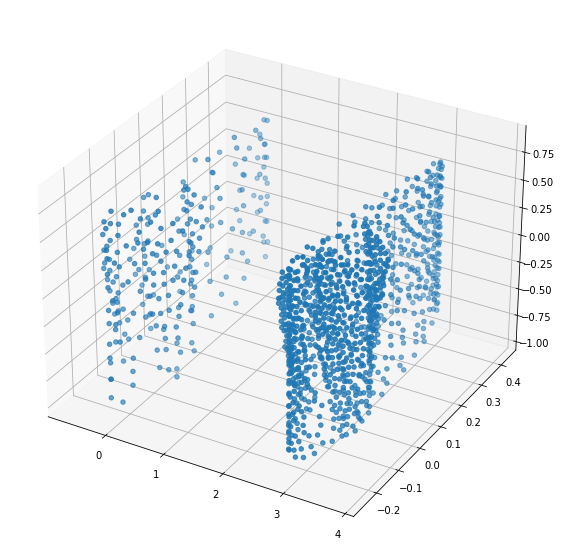

In [11]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([data_cloud, gt_cloud], ax = ax)

# Training

In [12]:
from pugcn_lib import PUGCN, PUInceptionTransformer

In [13]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [14]:
# Split into train and validation if you wish
# train_perc = .8
# trainset, valset = torch.utils.data.random_split(dataset , [int(len(dataset) * train_perc), int(len(dataset) * (1-train_perc)+1)], generator=torch.Generator().manual_seed(42))

In [15]:
# Set augmentation for the datasets
dataset.augment = train_config.augment
# trainset.dataset.augment = True
# valset.dataset.augment = False

In [16]:
trainloader = PyGLoader(dataset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
#trainloader = PyGLoader(trainset, batch_size=train_config.batch_size, follow_batch=['pos_s', 'pos_t'])
#valloader = PyGLoader(valset, batch_size=train_config.batch_size, shuffle=False, follow_batch = ['pos_s', 'pos_t'])



In [17]:
# model = PUGCN(
#     channels = model_config.channels,
#     k = model_config.k, # num_neighbours
#     r = model_config.r, # upsampling_ratio
#     dilations = model_config.dilations,
#     n_idgcn_blocks=model_config.n_idgcn_blocks,
#     n_dgcn_blocks=model_config.n_dgcn_blocks,
#     use_bottleneck = model_config.use_bottleneck,
#     use_pooling = model_config.use_pooling,
#     use_residual = model_config.use_residual,
#     conv = model_config.conv,
#     pool_type = model_config.pool
    
# ).to(device)

#model = PUGCN(**model_config).to(device)
model = PUInceptionTransformer(**model_config).to(device)
loss_fn = loss_fn = ChamferLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = train_config.lr, betas = train_config.betas)

In [18]:
model_size(model)

0.026

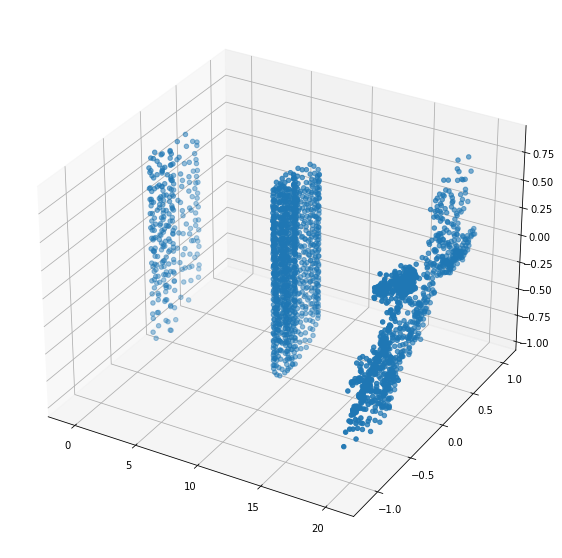

In [19]:
pred = model(data_cloud.to(device)).cpu().detach().numpy()
pred

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')

viz_many_mpl([data_cloud, gt_cloud, pred], d = 10, ax = ax)

In [20]:
def train(model, trainloader, loss_fn, optimizer):

    total_loss = 0.0
    for d in (t := tqdm(trainloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        # Train step
        optimizer.zero_grad()
        pred = model(p, batch=p_batch)
        
        pred, _ = to_dense_batch(pred, q_batch) # [B, N * r, 3]
        gt, _ = to_dense_batch(q, q_batch) # # [B, N * r, 3]
        d1, d2, _, _ = loss_fn(pred, gt)
        loss = d1.mean() + d2.mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss / len(trainloader.dataset)


@torch.no_grad()
def evaluate(model, valloader, loss_fn):

    total_loss = 0.0
    for d in (t := tqdm(valloader)):
        # Extract source and target point clouds and batches
        p, q = d.pos_s.to(device), d.pos_t.to(device)
        if trainloader.follow_batch:
            p_batch, q_batch = d.pos_s_batch.to(device), d.pos_t_batch.to(device)
        else:
            p_batch, q_batch = None, None

        pred = model(p, batch=p_batch)
        
        pred = to_dense_batch(pred, q_batch)  # [B, N * r, 3]
        gt = to_dense_batch(q, q_batch)  # [B, N * r, 3]
        d1, d2, _, _ = loss_fn(pred, gt)
        loss = d1.mean() + d2.mean()

        total_loss += loss.item()
        t.set_description(f"loss = {loss.item() :.4f}")
    return total_loss / len(trainloader.dataset)


In [21]:
if "trained-models" not in os.listdir("."):
    os.mkdir("trained-models")
dir_name = f'{datetime.now().strftime("%Y-%m-%d-%H-%M")}-{exp_conf.name}'

os.mkdir(os.path.join("trained-models", dir_name))
print(f"Saving checkpoints at {dir_name}")

Saving checkpoints at 2022-04-06-16-55-pupt-baseline


In [22]:
OmegaConf.save(config=exp_conf, f=os.path.join("trained-models", dir_name, "config.yaml"))

In [23]:
history = OmegaConf.create()
history.train_loss = []
history.val_loss = []
for epoch in tqdm(range(1, train_config.epochs + 1)):
    train_loss = train(model, trainloader, loss_fn, optimizer)
    history.train_loss.append(train_loss)
    #val_loss = evaluate(model, valloader, loss_fn)
    #history.val_loss.append(val_loss)
    
    print(f"{epoch=} \t {train_loss=:.6f}")
    
    if epoch == 1 or epoch % train_config.save_every == 0:
        torch.save(
            {
                "experiment_config": dict(exp_conf),
                "history": history,
                "epoch": epoch,
                "model_size": model_size(model, unit = "KB"),
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            },
            os.path.join("trained-models", dir_name, f"ckpt_epoch_{epoch}"),
        )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8625 [00:00<?, ?it/s]

/home/zademn/Big-Projects/Licenta/pugcn-pytorch/pugcn_lib/upsample.py:40: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  n_ = n // b  # N_ = number of points per batch


epoch=1 	 train_loss=0.000609


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=2 	 train_loss=0.000409


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=3 	 train_loss=0.000391


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=4 	 train_loss=0.000377


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=5 	 train_loss=0.000365


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=6 	 train_loss=0.000357


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=7 	 train_loss=0.000349


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=8 	 train_loss=0.000341


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=9 	 train_loss=0.000334


  0%|          | 0/8625 [00:00<?, ?it/s]

epoch=10 	 train_loss=0.000329


In [24]:
# Train 1 epoch 
#train_loss = train(model, trainloader, loss_fn, optimizer)


In [25]:
idx = np.random.choice(len(dataset))
#dv = valset[idx]
dv = dataset[idx]
sample, gt = dv.pos_s, dv.pos_t

In [26]:
pred = model(sample.to(device)).cpu().detach().numpy()
pred

array([[ 0.04105897, -0.17441429, -0.14552355],
       [ 0.02927584, -0.24503364, -0.14262238],
       [ 0.08215269, -0.17498247, -0.192673  ],
       ...,
       [ 0.7343662 ,  0.13281149,  0.42400843],
       [ 0.7480036 ,  0.16174324,  0.33479354],
       [ 0.7807798 ,  0.15791307,  0.4454093 ]], dtype=float32)

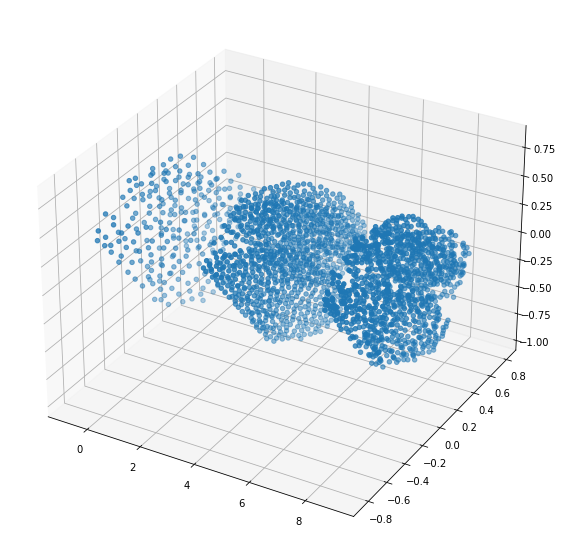

In [27]:
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection='3d')
viz_many_mpl([sample, gt, pred], d = 4, ax = ax)